# Geospatial Big Data Analytics

## 4th Project

### Pavlos Kalfantis - MSc Data Science and Machine Learning

The 4th project of the graduate course Geospatial Big Data Analytics is dealing with video classification, using Recurrent Neural Network architectures, as well as Transformers. 

There are two parts on this notebook, that serves as the report of the project. The first part consists of 5 steps that use Pytorch in order to classify the videos with two different families of models.
Steps 1,2 and 3 were completed during class and are included here for completeness. 

1. The first step was to download the dataset (UFC101) and complete a proper dataloader in order to feed the video data to the deep learning algorithms. 

2. The second step was to download the pretrained Resnet18 model (trained on the ImageNet dataset) that will be used as a feature extractor of the video frames

3. The third step was to design a recurrent neural network containing a [Gated Recurrent Unit (GRU)](https://en.wikipedia.org/wiki/Gated_recurrent_unit) 'gate' and train it on the dataset.

4. The fourth step, was to design and train a model with [Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model) mechanism.

5. Finally, the fifth step was to evaluate the model performance of our two models of steps 3 and 4, using a variety of metrics.

The second part of this project was to answer some theoretical questions about Recurrent Neural Networks and Machine Learning, presented on the last part of this notebook. 



# Part 1

# Step 1

# Download lightweight version of UCF101 dataset

In [ ]:
!pip install pytorch-lightning av

%load_ext tensorboard

In [2]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!mkdir data
!tar xf ucf101_top5.tar.gz --directory data

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1wJ_WN1khOrAyWOueYjT-WKsvi70F3gm_/view
#!mkdir data
!unzip precomputed_features.zip
!unzip precomputed_features/precomp.zip -d data/

In [4]:
from torch.utils.data import Dataset, DataLoader
from typing import Callable, List
import torch
import pandas as pd
import os
import numpy as np
from torchvision.io import read_video
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.transforms import ConvertImageDtype, Resize, Normalize
import pickle

# Step 2

# Define a data pipeline for NN training

The second step of this project was about creating a Dataset instance in Pytorch that would load the videos and make the necessary transformations in order to be fed in a RNN or a Transformer network. The videos are resized, normalized and then are transformed with the precomputed features of the ResNet18 Convolutional Neural Network (up to the second to last step). These transformations collapse 1 dimension of the video and each data sample now has two dimensions, sequence length (number of frames) and number of features (512 in ResNet18). Next step was to create a batching strategy, where each batch is zero padded since each sample has a different length.

In [5]:
# Define data root directory
DATA_ROOT = "data/"

# Define a Video-transform type
VTransform = Callable[[torch.Tensor], torch.Tensor]

class UCF101(Dataset):
    def __init__(self, data_root, mode="train", video_transforms: List[VTransform]=[], use_precomputed=True):
        '''
        Return a UCF101 Dataset instance
        '''
        super().__init__()
        assert mode in ["train", "test"]
        
        self.root = data_root
        self.mode = mode
        self.v_transforms = video_transforms
        
        # Build database of samples
        self._build_db()
        
        # Features precomute functionality
        self.pre = use_precomputed
        self.pre_root = os.path.join(self.root, "precomp")
        if self.pre and not os.path.exists(self.pre_root):
            os.makedirs(self.pre_root)
        
    def _build_db(self):
        '''
        Parse train/test csv containing paths to videos and corresponding labels.
        Also, assign a unique index to each category
        '''
        csv_file = os.path.join(self.root, self.mode + ".csv")
        self.db: np.ndarray = pd.read_csv(csv_file, header=0).values
        
        unique_categories = np.sort(np.unique(self.db.T[1]))
        self.categories = {c_name: c_idx for c_idx, c_name in enumerate(unique_categories)}
        
    def compute_sample(self, video_name, category):
        '''
        For a specific video, read data into memory, permute data to NumFrames x Channels x Height x Width format.
        Also, transform data according to list of transforms
        '''
        
        # Load video
        V, *_ = read_video(os.path.join(self.root, self.mode, video_name))
        # Permute data to NxCxHxW from NxHxWxC
        V = V.permute(0,3,1,2)
        
        for T in self.v_transforms:
            V = T(V)
        
        return V, self.categories[category]
        
    def __getitem__(self, index):
        '''
        Retrieve a specific sample from the dataset
        '''
        video_name, category = self.db[index]
        
        hval = "_".join([
            self.mode,
            video_name
        ])
        
        if os.path.exists(os.path.join(self.pre_root, f"{hval}.tmp")):
            with open(os.path.join(self.pre_root, f"{hval}.tmp"), "rb") as f:
                sample =  pickle.load(f)
        else:
            sample = self.compute_sample(video_name, category)
            # Save tmp
            with open(os.path.join(self.pre_root, f"{hval}.tmp"), "wb") as f:
                pickle.dump(sample, f)
            
        return sample
            
    def __len__(self):
        '''
        Returns the number of samples in the dataset
        '''
        return self.db.shape[0]

    
def compute_features() -> VTransform:
    '''
    Returns a VTransform object that uses a pretrained CNN to extract features
    '''
    # Instantiate a CNN for feature extraction
    encoder = resnet18(pretrained=True, progress=False)
    # model = nn.Sequential(*list(encoder.children())[:-1], nn.Flatten())
    model = create_feature_extractor(encoder, ["avgpool"])
    model.eval()
    
    def apply(v: torch.Tensor) -> torch.Tensor:    
        # return model(v)
        with torch.no_grad():
            feats = torch.flatten(model(v)["avgpool"], 1)
        return feats
    
    return apply
    

## Generate Dataloaders and batching strategy

In [6]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# Define train/val datasets
train_dset = UCF101(DATA_ROOT, "train", video_transforms=[
        ConvertImageDtype(torch.float32),
        Resize((224, 224)),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        compute_features()
    ])

val_dset = UCF101(DATA_ROOT, "test", video_transforms=[
        ConvertImageDtype(torch.float32),
        Resize((224, 224)),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        compute_features()
    ])


def pad_sequences_collate_fn(samples: List[tuple]) -> tuple:
    '''
    Zero-pad (in front) each sample to enable batching. The longest sequence defines the sequence length for the batch
    '''
    
    labels = torch.stack([torch.tensor(v[1]) for v in samples])
    data = pad_sequence([v[0] for v in samples])
    
    return data, labels

# Define train/val dataloaders with custom collate_fn for batching
train_dloader = DataLoader(train_dset, batch_size=16, collate_fn=pad_sequences_collate_fn, shuffle=True, num_workers=0)
val_dloader = DataLoader(val_dset, batch_size=16, collate_fn=pad_sequences_collate_fn, shuffle=False, num_workers=0)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


# Step 3

# Define a CNN-RNN Seq2Vec architecture

Step 3 is creating a Recurrent Neural Network architecture. A Gated Recurrent Unit model (GRU) is selected, decreasing the features from 512 to 31, which is then followed by a fully connected classifier that classifies the samples into the 5 categories. We have two sets of results of this model: One is the pretrained model that was provided through the course website, and the other is one that we are training based however on the precomputed features that we download (since this takes a very long time to compute). So each frame sample is loaded directly into a vector of size 512 (based on the precomputed ResNet 18 model) and then we train it for minimum 300 epochs

In [7]:
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
from torchmetrics import Accuracy, ConfusionMatrix

class Seq2Vec(pl.LightningModule):
    def __init__(self, features_in, num_classes, learning_rate=1e-3):
        '''
        Returns a Seq2Vec RNN model
        '''
        super().__init__()
        
        self.rnn_encoder = nn.GRU(
            input_size=features_in,
            hidden_size=32,
            num_layers=2,
            batch_first=False,
            dropout=0.3)
        
        self.classifier = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
        
        self.lr = learning_rate

        self.val_accuracy = Accuracy()        
        self.save_hyperparameters()
        
    def forward(self, x):
        '''
        Forward-pass
        '''
        rnn_out, h_n = self.rnn_encoder(x)
        #  rnn_out: L, B, 32
        return self.classifier(rnn_out[-1])

    def training_step(self, batch, batch_idx):
        '''
        Training logic
        '''
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/train", loss, on_epoch=True, on_step=False, batch_size=X.size()[1])

        return loss
    
    def validation_step(self, batch, batch_idx):
        '''
        Validation logic
        '''
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/val", loss, on_epoch=True, on_step=False, batch_size=X.size()[1])

        self.val_accuracy(logits, y)
        self.log("accuracy/val", self.val_accuracy, on_epoch=True, on_step=False, batch_size=X.size()[1])
    
    def configure_optimizers(self):
        '''
        Setup Adam optimizer
        '''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Train model!

In [10]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="accuracy/val", mode="max", patience=50),
    ModelCheckpoint(monitor="accuracy/val", mode="max", save_last=True)
]

rnn_model = Seq2Vec(512, len(train_dset.categories), learning_rate=1e-4)
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    min_epochs=300,
    max_epochs=1000,
    callbacks=callbacks,
    default_root_dir="seq2vec_gru"
)

trainer.fit(rnn_model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | rnn_encoder  | GRU        | 58.8 K
1 | classifier   | Sequential | 613   
2 | val_accuracy | Accuracy   | 0     
--------------------------------------------
59.4 K    Trainable params
0         Non-trainable params
59.4 K    Total params
0.237     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (300) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

In [ ]:
%tensorboard --logdir seq2vec_gru/lightning_logs

In [ ]:
# Load pretrained model to compare with the one trained here

pretrained_model = Seq2Vec.load_from_checkpoint('/content/data/lab4_gru_pretrained.ckpt')


# Step 4

# Define a Transformer Architecture

The fourth step was to build a second model, based on the Transformer architecture. More specifically, only the encoder part of the Transformer is used in order to encode the sequence of video frames before it is fed through the fully connected Neural Network that classifies the videos into the 5 categories. Two important additional steps are required: First, Since transformers process sequences as sets, they are, in theory, permutation invariant. Thus the PositionalEncoding module  is required as a first step. Positional encoding describes the location or position of an entity in a sequence so that each position is assigned a unique representation. There are many reasons why a single number such as the index value is not used to represent an item’s position in transformer models. For long sequences, the indices can grow large in magnitude. If you normalize the index value to lie between 0 and 1, it can create problems for variable length sequences as they would be normalized differently. Transformers use a smart positional encoding scheme, where each position/index is mapped to a vector. Hence, the output of the positional encoding layer is a matrix, where each row of the matrix represents an encoded object of the sequence summed with its positional information. 

Secondly, a proper padding mask needs to be applied to the input signals, because during batching the signals with length less than the max were zero padded in order to have the same dimensions. These zeros cannot go through the transformer encoder so they are masked and ignored during the forward function. The output at this point has dimensions (S, N, E) where S is the sequence length, N is the batch size and E=512 are the features. This needs to be transfomred into (N, E) in order to be used by the fully connected neural network, so the max value in the 1st dimension (S) is selected for each sample. The final step is the fully connected NN, where two hidden layers are selected in order to connect the 512 inputs to the 5 outputs (categories). The model is trained using 100 epochs and the lighning logs are shown below.

In [15]:
from torch import nn
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int,  max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return x

In [16]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, MaxPool1d

class Transformer(pl.LightningModule):
    def __init__(self, d_model: int = 512, num_classes: int = 5, nhead: int = 8, nlayers: int = 4, learning_rate = 1e-4):

        super().__init__()

        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)  
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
        
        self.lr = learning_rate

        self.val_accuracy = Accuracy()        
        self.save_hyperparameters()
        
    def forward(self, x):
        '''
        Forward-pass
        '''
        src_padding_mask = (x == 0).amin(dim=2).transpose(0, 1)
        src = self.pos_encoder(x)
        output = self.transformer_encoder(src, src_key_padding_mask = src_padding_mask)
        output_max = output.amax(dim=0)

        return self.classifier(output_max)

    def training_step(self, batch, batch_idx):
        '''
        Training logic
        '''
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/train", loss, on_epoch=True, on_step=False, batch_size=X.size()[1])

        return loss
    
    def validation_step(self, batch, batch_idx):
        '''
        Validation logic
        '''
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/val", loss, on_epoch=True, on_step=False, batch_size=X.size()[1])

        self.val_accuracy(logits, y)
        self.log("accuracy/val", self.val_accuracy, on_epoch=True, on_step=False, batch_size=X.size()[1])
    
    def configure_optimizers(self):
        '''
        Setup Adam optimizer
        '''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [17]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="accuracy/val", mode="max", patience=50),
    ModelCheckpoint(monitor="accuracy/val", mode="max", save_last=True)
]

transformer_model = Transformer()
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    min_epochs=50,
    max_epochs=200,
    callbacks=callbacks,
    default_root_dir="seq2vec_tra"
)

trainer.fit(transformer_model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: seq2vec_tra/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | pos_encoder         | PositionalEncoding | 0     
1 | transformer_encoder | TransformerEncoder | 12.6 M
2 | classifier          | Sequential         | 34.0 K
3 | val_accuracy        | Accuracy           | 0     
-----------------------------------------------------------
12.6 M    Trainable params
0         Non-trainable params
12.6 M    Total params
50.574    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%tensorboard --logdir seq2vec_tra/lightning_logs

# Step 5 - Evaluation

For the final step of this first part of the project, the models are evaluated using the well known classification metrics of accuracy, precision, recall and F1 Score. Scikit learn's classification report provides this information for multi class classification, where the metrics are presented as an averaged, as well as per category. In addition, ConfusionMatricDisplay displays the confusion matrix for all the test data, showing the number of validation data samples that are classified correctly on each category. 

We can see that the transformer model outperforms the RNN models (both pretrained and trained here) with an average accuracy of ~96% compared to ~92% achieved the Recurrent Neural Networks using the Gated Recurrent Unit gating mechanism (when is trained in many epochs). 

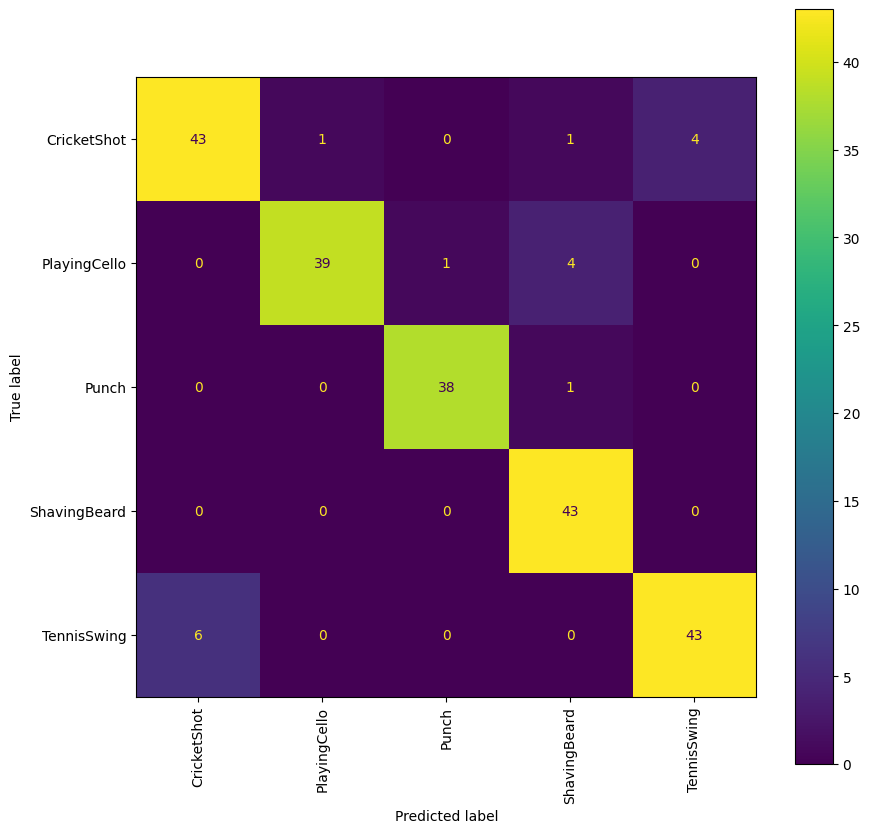

              precision    recall  f1-score   support

 CricketShot       0.88      0.88      0.88        49
PlayingCello       0.97      0.89      0.93        44
       Punch       0.97      0.97      0.97        39
ShavingBeard       0.88      1.00      0.93        43
 TennisSwing       0.91      0.88      0.90        49

    accuracy                           0.92       224
   macro avg       0.92      0.92      0.92       224
weighted avg       0.92      0.92      0.92       224



In [11]:
# Model 1 - RNN

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

predictions_list = []
targets_list = []

rnn_model.eval()
for batch_sample in val_dloader:
    X = batch_sample[0]#.cuda()
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = rnn_model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)
# Normalize CM to precision metric
cm_prec = cM / cM.sum(axis=0)
# Normalize CM to recall metric
cm_rec = (cM.T / cM.sum(axis=1)).T

CLASS_NAMES = train_dset.categories.keys()

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

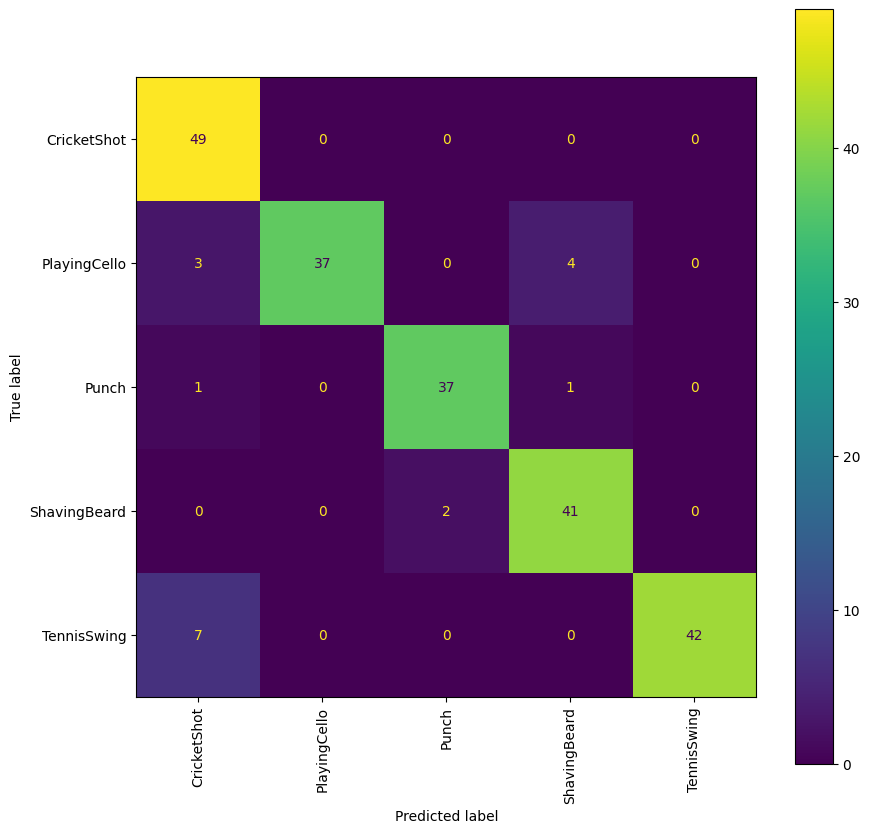

              precision    recall  f1-score   support

 CricketShot       0.82      1.00      0.90        49
PlayingCello       1.00      0.84      0.91        44
       Punch       0.95      0.95      0.95        39
ShavingBeard       0.89      0.95      0.92        43
 TennisSwing       1.00      0.86      0.92        49

    accuracy                           0.92       224
   macro avg       0.93      0.92      0.92       224
weighted avg       0.93      0.92      0.92       224



In [ ]:
#Model 2 - Pretrained RNN

predictions_list = []
targets_list = []

pretrained_model.eval()
for batch_sample in val_dloader:
    X = batch_sample[0]#.cuda()
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = pretrained_model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)
# Normalize CM to precision metric
cm_prec = cM / cM.sum(axis=0)
# Normalize CM to recall metric
cm_rec = (cM.T / cM.sum(axis=1)).T

CLASS_NAMES = train_dset.categories.keys()

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

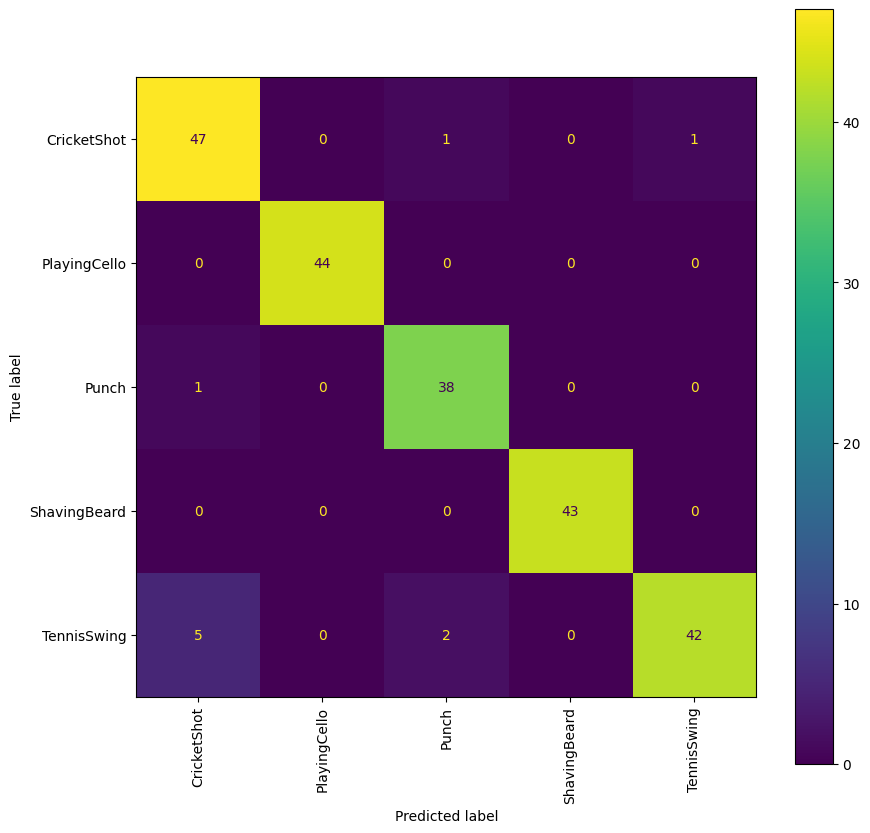

              precision    recall  f1-score   support

 CricketShot       0.89      0.96      0.92        49
PlayingCello       1.00      1.00      1.00        44
       Punch       0.93      0.97      0.95        39
ShavingBeard       1.00      1.00      1.00        43
 TennisSwing       0.98      0.86      0.91        49

    accuracy                           0.96       224
   macro avg       0.96      0.96      0.96       224
weighted avg       0.96      0.96      0.96       224



In [18]:
#Model 3 - Transformer

predictions_list = []
targets_list = []

transformer_model.eval()
for batch_sample in val_dloader:
    X = batch_sample[0]#.cuda()
    y = batch_sample[1].numpy()
    targets_list.append(y)
    
    # Infer with the model
    with torch.no_grad():
        preds = transformer_model(X)
    
    predictions_list.append(torch.argmax(preds, dim=-1).cpu().numpy())
predictions = np.concatenate(predictions_list, axis=0)
targets = np.concatenate(targets_list, axis=0)


cM = confusion_matrix(targets, predictions)
# Normalize CM to precision metric
cm_prec = cM / cM.sum(axis=0)
# Normalize CM to recall metric
cm_rec = (cM.T / cM.sum(axis=1)).T

CLASS_NAMES = train_dset.categories.keys()

disp = ConfusionMatrixDisplay(confusion_matrix=cM,
                               display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes()

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

print(classification_report(targets, predictions, target_names=CLASS_NAMES))

# Part 2 - Questions

## Question 1

Using a bi-directional RNN is not possible for the classification task of streaming video.A Bidirectional RNN is a combination of two RNNs training the network in opposite directions, one from the beginning to the end of a sequence, and the other from the end of the sequence to the beginning. Since in online classification of streaming video there is no end of the sequence, the use of a B-RNN does not work in encoding it.

## Question 2

Precision is defined as the number of true positives over the number of true positives plus the number of false positives. Recall is defined as the number of true positives over the number of true positives plus the number of false negatives. Precision and recall are both very important metrics for any classification task. However, depending on the task, sometimes one is more important than the other.

Recall is more important where Overlooked Cases (False Negatives) are more costly than False Alarms (False Positive). When the predictive model is used for a security application, for example when we use it to identify abnormal behavior in an email system, classifying abnormal behavior as normal can have serious consequences. Thus, False Negatives (predicting something is not positive while it is, with positive being the abnormal behavior) should me limited as much as possible, or consequently, have a value of recall as high as possible

## Question 3

Because of the architecture of Recurrent Neural Networks, especially in deep architectures, exploding gradients is a common problem. By exploding gradient problem, we refer to the problem of the calculated gradients getting exponentially higher at each step and approaching infinity after certain epochs. This problem of the original RNN architecture can be tackled with a variety of methods. 

One of the most commonly used methods is gradient clipping, which sets an upper limit to the value of the gradient during backpropagation, thus not allowing it going to very high values.

Another approach, if exploding gradients are still occurring, is to check the size of network weights and apply a penalty to the networks loss function for large weight values. This is called weight regularization and often an L1 (absolute weights) or an L2 (squared weights) penalty can be used.


